In [1]:
# Setup for the notebook: imports and set log levels to not produce too much output
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Bilby imports
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform

# This is just to reduce the overall output, remove this when running locally
bilby.utils.setup_logger(log_level="WARNING")

# This is just to make things "pretty" for presentation
import seaborn
np.random.seed(123)
seaborn.set_context("talk")
seaborn.set_style("whitegrid")

# Pre-workshop

You need to install the relevant software, for this tutorial all you will need to do is run

```
$ pip install bilby
```

You can check this works by doing the following:

In [2]:
import bilby
print(bilby.__version__)

0.5.9: (UNCLEAN) 73c0261 2019-11-18 16:11:58 +1100


There will be other software used throughout. But this is just for examples and isn't required to get started.

# Inference/Data analysis workshop: overview

- An aside on conditional probability and Bayes' theorem/one-liner
- Introduction to inference
- Inference from scratch
- Bilby as a black box
- Bilby likelihoods
- Bilby priors
- Bilby model selection

## An aside on conditional probability and Bayes' theorem/one-liner

- Throughout this tutorial, we'll be using the oft-talked about [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$

- Before we begin, let's make sure we understand it

**Question:** What is the probability of drawing a red-suit card from a pack of 52 cards?

**Answer:** It is 1/2 *if* the 52-card deck of cards is normal

**Question:** How do you express that mathematically?

**Answer:**

$$ P(\textrm{red-card} | I) = \frac{1}{2} $$

where

$$ I \equiv \textrm{"normal 52-card deck"} $$

is our *background* information.

*The vertical line above can be read as "given"*

**Question:** What is the probability of drawing <span style="color:red"> 2 red-suit card from a pack of 52 cards</span>?

**Answer:** Uhh.. hang on let me draw a diagram
```
           O      
        /     \
       /       \
      R0       B0
      / \      /\
     /   \    /  \
    R1   B1  R1  B1
```

So...
$$R_0 = \frac{26}{52}=\frac{1}{2} \;\; \textrm{ and }\;\; R_1=\frac{26-1}{52-1}=\frac{25}{51}$$
so the probability of both occuring is 
$$ R_1 \times R_0 = \frac{25}{102} $$

**Question:** How do you express that mathematically?

**Answer:** We want $P(R_0, R_1| I)$, so we need to use *conditional probability*

$$ P(R_0, R_1| I) = P(R_1 | R_0, I) P(R_0| I) $$

with
$$ P(R_0 | I) = \frac{1}{2} $$
and
$$ P(R_1 | R_0, I) = \frac{\textrm{Number of red cards}}{\textrm{Number of cards}} = \frac{26-1}{52-1} = \frac{25}{51} $$

And so finally
$$ P(R_0, R_1| I) = \frac{1}{2} \times \frac{25}{51} = \frac{25}{102}$$

### Okay sorry, where were we?

You all understand conditional probability 
$$P(A, B| I ) = P(A| B, I)P(B, I)$$

But we can write that the other way around
$$P(A, B| I ) = P(B| A, I)P(A, I)$$

Then with a little algebra

$$ P(A| B, I) = \frac{P(B| A, I) P(A| I)}{P(B| I)} $$

- Which is just... Bayes' theorem.

- Maybe we should just call it Bayes' one-liner?

## Introduction to Inference

- **Inference is about figuring something out from the data**

- We will label, for now, our data as $\textbf{data}$

- Once you have some data it is time to decide what you want to figure out.

- Inference can be thought of in two ways:
  1. **Parameter estimation**: "*I want to figure our what model parameters $\theta$ best-fit my data, given some model $M_A$*"
  2. **Model selection**: "*I want to figure our which model, $M_A$ or $M_B$ best fits my data*"

## Parameter Estimation

Parameter estimation is about figuring out the model parameters $\theta$ given some model $M_A$

$$ P(\theta| M_A, \mathbf{data}) = \frac{P(\mathbf{data}| M_A, \theta) P(\theta | M_A)}{P(\mathbf{data} | M_A)}$$

The denomoninator here only normalises the distribution, so often people will simplify

$$ P(\theta| M_A, \mathbf{data}) \propto P(\mathbf{data}| M_A, \theta) P(\theta | M_A)$$

For consistency with notation elsewhere, this is often written

$$ \underbrace{P(\theta| M_A, \mathbf{data})}_{\textrm{posterior}} \propto \underbrace{\mathcal{L}(\mathbf{data}| M_A, \theta)}_{\textrm{likelihood}} \underbrace{\pi(\theta | M_A)}_{\textrm{prior}}$$

### Example 1: one-dimensional posterior distribution

Let's talk about some specific data $\mathbf{y} = [y_0, y_1, \ldots, y_N]$ observed at times $\mathbf{t} = [t_0, t_1, \ldots, t_N]$.

To be concrete: we will say

- Our model is
$$ M_A: y_A(t; \omega) = \sin(\omega t) $$
- We have one model parameter, i.e. $\mathbf{\theta}=[\omega]$

In [2]:
def modelA(time, omega):
    return np.sin(omega * time)

Okay, let's simulate some data

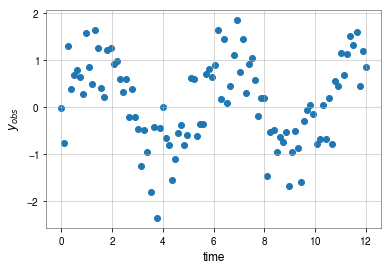

In [17]:
sigma = 0.5
omega_true = 1.2
time = np.linspace(0, 12, 100)
ydet = modelA(time, omega=omega_true)
yobs = ydet + np.random.normal(0, sigma, len(time))  # Observed data = SIGNAL + GAUSSIAN NOISE

plt.plot(time, yobs, "o")
plt.ylabel("$y_{obs}$"); plt.xlabel("time")
plt.show()

We want to *figure something out from the data*. Let's figure out the frequency

The *noise* is Gaussian, i.e. we have

$$ y_\textrm{obs} = y_\textrm{det} + \textrm{noise} => \textrm{noise} = y_\textrm{obs} - y_\textrm{det}$$

So, if we have a single data point $y_i, t_i$, then given a particular $\omega$

$$\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = \textrm{Normal}(y - y_A(t; \omega); \sigma=0.1) 
= \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}\left(-\frac{(y_i-y(t_i)^2)}{2\sigma^2}\right)$$

It is a good idea to work with the log-likelihood
$$ \ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = -\frac{1}{2}\left(
\frac{(y_i-y_A(t_i))^2}{\sigma^2} + \ln({2\pi\sigma^2})
\right)$$

Last, we want the likelihood from **all** the data:
$$\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \prod_{i}\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$
or
$$\ln\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \sum_{i}\ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$

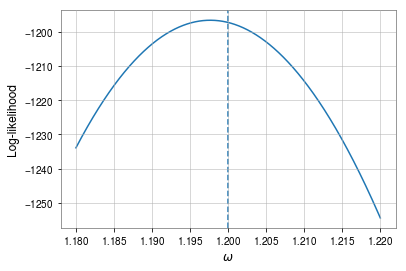

In [18]:
def ln_likelihood(yobs, time, omega, sigma=0.1):
    yA = modelA(time, omega)
    ln_likes = -0.5 * ((yobs - yA)**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return np.sum(ln_likes)

omega_grid = np.linspace(omega_true-2e-2, omega_true+2e-2, 1000)
ln_likelihood_grid = []
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(yobs, time, omega))
    
plt.plot(omega_grid, ln_likelihood_grid)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("Log-likelihood")
plt.show()

### Max likelihood

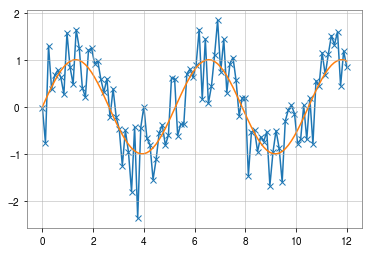

In [19]:
max_likelihood_omega = omega_grid[np.argmax(ln_likelihood_grid)]
plt.plot(time, yobs, '-x')
plt.plot(time, modelA(time, max_likelihood_omega))
plt.show()

## Posteriors

$$ P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega) \times \pi(\omega) $$

- If $\pi(\omega) \propto \textrm{const.}$, then $P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega)$
- If not, then one needs to do multiply by the prior.
- For the time being let's take the easier case

### Normalised posterior density function (pdf)

Let's plot the posterior (equal to the likelihood in this case) taking an exponent

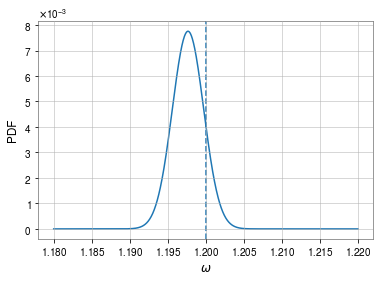

In [20]:
pdf_unnormalized = np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid))
pdf_normalized = pdf_unnormalized / np.sum(pdf_unnormalized)
plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()

### Why is the peak not consistent with the true value?

- Cleary the median of this distribution does **not** agree with the true value
- The *noise* in the observed data means that we have uncertainty!
- How can be quantify this?
- Bayesian answer is the [credible interval](https://en.wikipedia.org/wiki/Credible_interval) 
- We should always report inferences as $\omega$ has a median of XX and lies between YY and ZZ with 95\% probability
- How do we figure out these numbers?

## Cumulative distribution

First, let's calculate the cumulative distribution function

$$ \mathrm{CDF}(\omega) = \int_{-\infty}^{\omega} P(\omega'| \mathrm{data})\, d\omega' $$

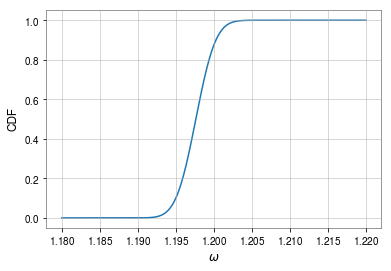

In [21]:
cdf = np.cumsum(pdf_normalized)
plt.plot(omega_grid, cdf)
plt.xlabel("$\omega$")
plt.ylabel("CDF")
plt.show()

- The median is the point where the CDF passes through 0.5
- We can find the 90% confidence interval by finding the 0.05 and 0.95 numbers (such that the interval contains 90% of the probability)

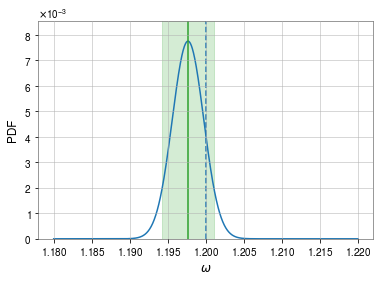

In [22]:
median = omega_grid[np.argmin(np.abs(cdf - 0.5))]
low_bound = omega_grid[np.argmin(np.abs(cdf - 0.05))]
upper_bound = omega_grid[np.argmin(np.abs(cdf - 0.95))]

plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.fill_between([low_bound, upper_bound], 0, 2 * np.max(pdf_normalized), color='C2', alpha=0.2)
plt.axvline(median, color='C2')
plt.ylim(0, 1.1 * np.max(pdf_normalized)); plt.xlabel("$\omega$"); plt.ylabel("PDF")
plt.show()

## What happens when things get more complicated?

- In low-dimensions, evaluating a grid of points isn't too crazy
- In high-dimensionl problems, the number of grid points scales with the number of dimensions!
- Here we turn to stochastic sampling algorithms

## First, let's build a peak-finding algorithm


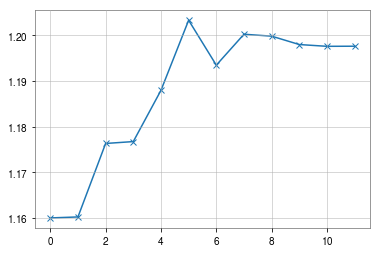

In [23]:
omega_values = [1.16] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1]:
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
        
plt.plot(omega_values, '-x')
plt.show()

- Good at finding the peak of a unimodel likelihood to arbitrary precision
- Bad if things are multimodal
- Doesn't tell us anything about the "structure"

### Very basic Metropolis-Hastings sampler

Markov-Chain Monte-Carlo samplers use "randomness" to sample from the posterior distribution

*EDIT* After presenting this Meg Millhouse (Uni Mel.) reminded me that the function was missing the `else` statement which is important to make sure the posterior samples are really samples from the posterior (see detailed balance in any good textbook).

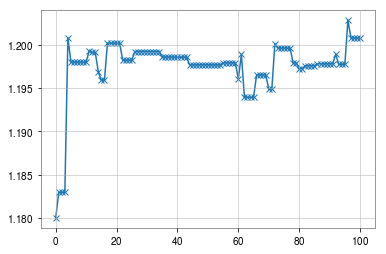

In [29]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Run it with a few more steps...

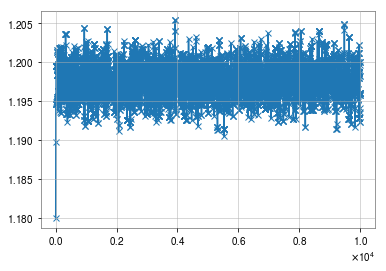

In [31]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(10000):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Histogram the samples

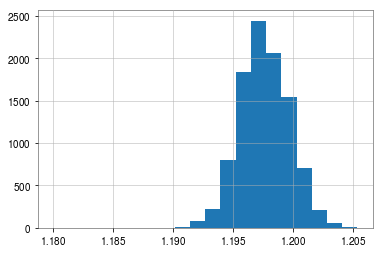

In [32]:
_ = plt.hist(omega_values, bins=20)

## Sampling takeaways

- Stochastic samplers are all about drawing "samples" from the posterior distribution

- Simple MCMC methods need tuning

- Advanced MCMC methods have fewer tuning parameters
  - Parallel tempering is required to deal with multi-model distributions
  - Can calculate evidences, but not advised
  
- Nested Sampling is better than MCMC
  - Calculated evidences by design
  - Deals well with multimodal distributions

## Using Bilby

- All of this was very interesting, but what is this about marsupials?

<img src="https://git.ligo.org/uploads/-/system/project/avatar/1846/bilby.jpg?width=64" alt="drawing" width="300"/>

## Bilby provides a easy-to-use interface for common inference tasks

Let's repeat what we did above, but in bilby

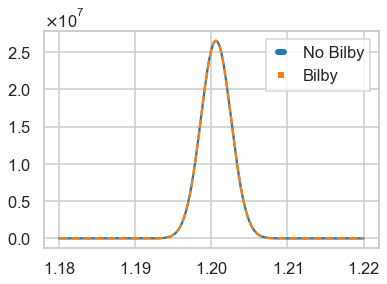

In [15]:
likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelA, sigma=0.1)

ln_likelihood_grid_bilby = []
for omega in omega_grid:
    likelihood.parameters["omega"] = omega
    ln_likelihood_grid_bilby.append(likelihood.log_likelihood())
    
plt.plot(omega_grid, np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid)), label="No Bilby")
plt.plot(omega_grid, np.exp(ln_likelihood_grid_bilby - np.mean(ln_likelihood_grid_bilby)), '--', label="Bilby")
plt.legend()
plt.show()

## Increasing complexity

- What happens if we increase the complexity?
- What if our model looks like this

$$ y_B(t) = A\sin(\omega t + \phi_0)$$

- And we don't know what $\sigma$ is?

We **could** repeat the operation above:
- Create a grid (now in 4D)
- Evaluate the likelihood over the grid and find a maximum

**But**: the number of grid point we need is $\propto (\textrm{the grid spacing})^N$

## Stochastic Sampling methods: as a black box

In [25]:
def modelB(time, omega, A, phi0):
    return A * np.sin(omega * time + phi0)

likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelB)

priors = dict(
    A=Uniform(0, 2, "A"),
    omega=Uniform(1, 1.5, "omega"),
    phi0=Uniform(-np.pi, np.pi, "phi0", boundary='reflective'),
    sigma=Uniform(0, 2, "sigma"))

result = bilby.run_sampler(
    likelihood, priors=priors, nlive=500, sample='unif', outdir="test-outdir", label="black-box",
    injection_parameters=dict(A=1, omega=omega_true, phi0=0, sigma=sigma),
    clean=True)

6766it [00:31, 200.93it/s, bound:31 nc:2 ncall:27515 eff:24.6% logz=-85.59+/-0.19 dlogz:0.135>0.10]  
6914it [00:32, 213.91it/s, bound:31 nc:1 ncall:27752 eff:26.7% logz=-85.49+/-0.20 dlogz:0.000>0.10]



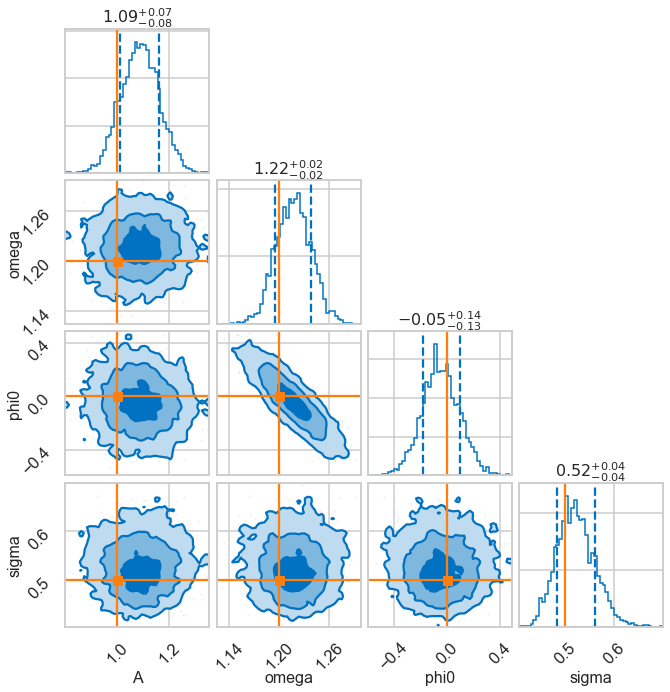

In [26]:
# Dashed lines give 90% C.I.
result.plot_corner()

# What is going on here?

- Bilby has used a [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) algorithm [dynesty](https://dynesty.readthedocs.io/en/latest/) to evaluate the posteriors
- The posterior output are a set of samples
- The samples are "points drawn from the posterior distribution"
- Stored in a pandas DataFrame

In [21]:
result.posterior.head()

,A,omega,phi0,sigma,log_likelihood,log_prior
0,1.003450,1.188878,-0.249687,0.619355,-81.421932,-2.531024
1,1.117757,1.167952,0.053798,0.544522,-80.551198,-2.531024
2,0.738149,1.260363,-0.144292,0.620363,-80.044291,-2.531024
3,0.984405,1.190735,-0.219958,0.612040,-79.682334,-2.531024
4,0.750257,1.269990,-0.288952,0.422693,-79.407834,-2.531024


## Using the samples

You can use the samples in all sorts of ways, for example let's plot the 1D marginalised distribution for omega

(0, 25)

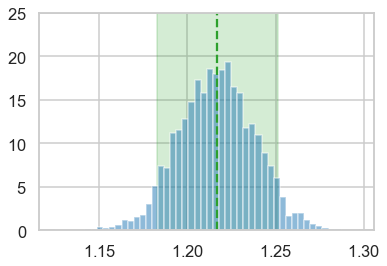

In [27]:
omega_samples = result.posterior["omega"]
median = np.quantile(omega_samples, 0.5)
low_bound = np.quantile(omega_samples, 0.05)
upper_bound = np.quantile(omega_samples, 0.95)

plt.fill_between([low_bound, upper_bound], 0, 200, color='C2', alpha=0.2)
plt.axvline(median, ls="--", color="C2")
_ = plt.hist(omega_samples, bins=50, density=True, alpha=0.5)
plt.ylim(0, 25)

### Looking at the posterior uncertainty
We might want to know what range of curves are data supports

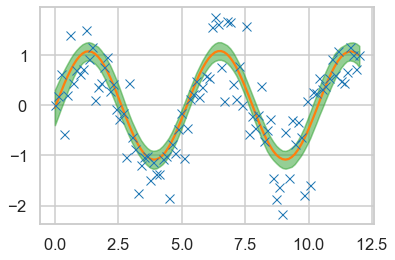

In [28]:
y_pred = []
for _, sample in result.posterior.sample(1000).iterrows():
    y_pred.append(modelB(time, **{k:sample[k] for k in likelihood.model_parameters.keys()}))
    
median = np.quantile(y_pred, 0.5, axis=0)
lower = np.quantile(y_pred, 0.01, axis=0)
upper = np.quantile(y_pred, 0.99, axis=0)
plt.plot(time, median, color='C1')
plt.fill_between(time, lower, upper, color="C2", alpha=0.5)

plt.plot(time, yobs, 'x')
plt.show()

## Using the `results` objects

The `result` object is where all the output is stored. It is stored to disk (by default in a `json` format)

In [29]:
print(result.outdir)  # Set in the `run_sampler()` call

/home/user1/OzGravECR/test-outdir


In [30]:
!ls /home/user1/test-outdir

black-box_1d			black-box_plot_with_data.png
black-box_checkpoint_trace.png	black-box_result.json
black-box_corner.png		black-box_resume.pickle
black-box_dynesty.pickle


In [31]:
!head /home/user1/test-outdir/black-box_result.json

{
  "label": "black-box",
  "outdir": "/home/user1/test-outdir",
  "sampler": "dynesty",
  "log_evidence": -78.89969252798156,
  "log_evidence_err": 0.1980948729047665,
  "log_noise_evidence": NaN,
  "log_bayes_factor": NaN,
  "priors": {
    "A": {


## You can load the result up

In [32]:
result_loaded = bilby.result.read_in_result("test-outdir/black-box_result.json")

## Check a traceplot of the runs

display: test-outdir/black-box_checkpoint_trace.png

![image](test-outdir/black-box_checkpoint_trace.png)

## Access attributes

In [33]:
print(result_loaded.log_evidence)
print(result_loaded.injection_parameters)
print(result_loaded.sampling_time)  # In seconds
print(result.version)

-85.49404540166941
{'A': 1, 'omega': 1.2, 'phi0': 0, 'sigma': 0.5}
31.186952
bilby=0.5.9: (UNCLEAN) 73c0261 2019-11-18 16:11:58 +1100


## Make corner plots with truths

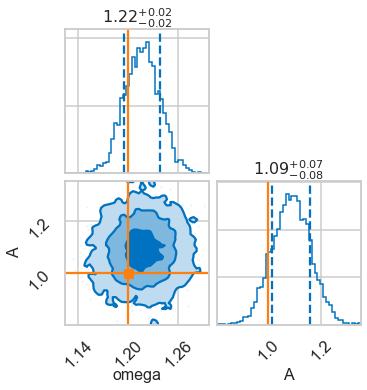

In [34]:
result.plot_corner(dict(omega=omega_true, A=1))

## Make corner plots without truths

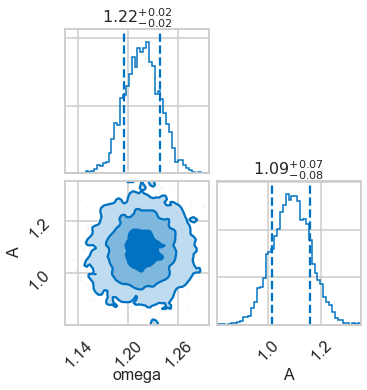

In [35]:
result.plot_corner(['omega', 'A'])

## Plot single densities

Here is the PDF and CDF

In [36]:
result.plot_marginals(['omega'], priors=True)

<img src="test-outdir/black-box_1d/omega_pdf.png" alt="Drawing" style="width: 300px;"/>
<img src="test-outdir/black-box_1d/omega_cdf.png" alt="Drawing" style="width: 300px;"/>

## Too much black box: show me the guts!

Let's start by taking a look at the likelihood. This object we created has a two important antributes:

**1.** A dictionary of the current set of parameters

In [37]:
likelihood.parameters

{'omega': 1.2051472249846134,
 'A': 1.1132111457889624,
 'phi0': 0.06000743289392618,
 'sigma': 0.49787435307113953}

**2.** A dictionary of the current set of parameters

In [38]:
likelihood.log_likelihood()

-74.43705496260786

### Let's make a likelihood!

We'll repeat the work above, but for the $\omega$ case only, making a **special** likelihood to do it

In [39]:
class MyLikelihood(bilby.likelihood.Likelihood):
    def __init__(self, yobs, time):
        super(MyLikelihood, self).__init__()
        self.sigma = 0.1
        self.yobs = yobs
        self.time = time
        self.parameters = dict(omega=None)

    def model(self):
        return np.sin(self.parameters['omega'] * self.time)
    
    def log_likelihood(self):
        sigma = self.sigma
        ymodel = self.model()
        return np.sum(-0.5 * ((self.yobs - ymodel)**2 / sigma**2 + np.log(2*np.pi*sigma**2)))
    
my_likelihood = MyLikelihood(yobs, time)
priors = dict(omega=bilby.prior.Uniform(1, 1.5, 'omega'))
result = bilby.run_sampler(my_likelihood, priors=priors)

6830it [00:11, 389.59it/s, bound:96 nc:22 ncall:93392 eff:7.3% logz=-1175.38+/-0.09 dlogz:0.103>0.10] 
6854it [00:11, 572.89it/s, bound:97 nc:1 ncall:93848 eff:8.4% logz=-1175.28+/-0.09 dlogz:0.000>0.10] 



## Limitations

- The likelihood can get arbitrarily complicated, provided it has
  - `parameters` dictionary
  - `log_likelihood()`

### Example: A quantum likelihood

- Returns a random number generated with The ANU Quantum Random Number Generator (qrng.anu.edu.au).
- You will need
```bash
$ pip install quantumrandom
```

In [40]:
import quantumrandom

class QuantumLikelihood(bilby.likelihood.Likelihood):
    """ A likelihood which returns a random numbers form The ANU Quantum Random Number Generator \
    
    See qrng.anu.edu.au
    
    """
    def __init__(self):
        super(QuantumLikelihood, self).__init__()
        self.parameters = dict(A=None)
    
    def log_likelihood(self):
        A = self.parameters["A"]
        return A * quantumrandom.get_data()[0]
    
qlike = QuantumLikelihood()
qlike.parameters["A"] = 1
qlike.log_likelihood()

488

### Example: A chirp likelihood

- Let's build a (not good) likelihood for GW150914
- First we need to get some data
- You will need
```bash
$ pip install gwpy
```
- Based on https://gwpy.github.io/docs/latest/examples/signal/gw150914.html

### Download the data

In [41]:
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

trigger_time = 1126259462
duration = 8
post_trigger_duration = 4
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration
data = TimeSeries.fetch_open_data("H1", start_time, end_time, verbose=True)

Fetched 1 URLs from www.gw-osc.org for [1126259458 .. 1126259466))
Reading data... [Done]


### Filter, notch and cut out the interesting bit

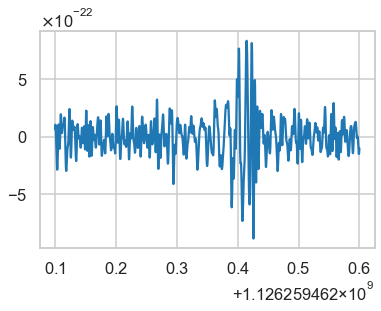

In [42]:
bp = filter_design.bandpass(50, 300, data.sample_rate)
notches = [filter_design.notch(line, data.sample_rate) for line in (60, 120, 180, 240, 300)]
zpk = filter_design.concatenate_zpks(bp, *notches)
filt = data.filter(zpk, filtfilt=True)

filt = filt[filt.times.value > 1126259462.1]
filt = filt[filt.times.value < 1126259462.6]

hoft = filt.value
hoft_time = filt.times.value
plt.plot(hoft_time, hoft)
plt.show()

### Plot in a  time-frequency spectrogram

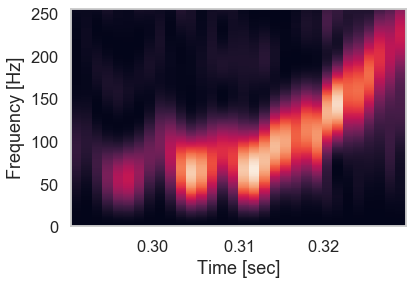

In [43]:
fs = filt.sample_rate.value
from scipy import signal
freqs, times, Sxx = signal.spectrogram(hoft, fs, nperseg=50, noverlap=45, nfft=2**12, window=('tukey', 0.01))
time_idxs = (times > 0.29) * (times < 0.33)
freq_idxs = freqs < 256
Sxx = Sxx[:, time_idxs][freq_idxs, :]
times = times[time_idxs]
freqs = freqs[freq_idxs]
plt.pcolormesh(times, freqs, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### The "model"

See Cutler & Flanagan (1994) Eq 1.13

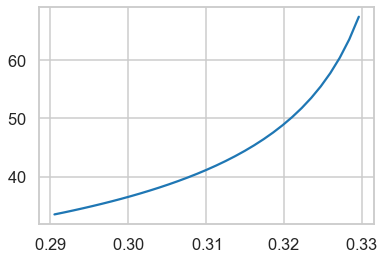

In [44]:
from scipy.constants import G, c
from scipy.integrate import odeint
Msun = 2e30

def dfdt(f, t, Mc): 
    """ Cutler & Flanagan Eq. 2.13"""
    return 96/5. * np.pi**(8/3) * (Mc * Msun * G) ** (5/3) / c**5 * f** (11/3) 

f = odeint(dfdt, t=times, y0=33.5, args=(70,))
plt.plot(times, f)
plt.show()

### The likelihood

In [45]:
class ChirpLikelihood(bilby.likelihood.Likelihood):
    def __init__(self, times, freqs, Sxx):
        super(ChirpLikelihood, self).__init__()
        self.times = times
        self.freqs = freqs
        self.Sxx = Sxx
        self.parameters = dict(Mc=None, f0=None)

    def cutler_flanagan_frequency(self):
        Mc = self.parameters["Mc"]
        f0 = self.parameters["f0"]
        return odeint(dfdt, t=self.times, y0=f0, args=(Mc,))
    
    def log_likelihood(self):
        predicted_freqs = self.cutler_flanagan_frequency()
        self.idxs = [np.argmin(np.abs(self.freqs-f)) for f in predicted_freqs]
        return np.log(np.trace(self.Sxx[self.idxs]))

### Sample!

/home/user1/anaconda3/envs/bilby/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3610it [03:02,  1.93it/s, bound:1 nc:5 ncall:36135 eff:10.0% logz=-102.37+/-0.05 dlogz:0.393>0.10]  

/home/user1/anaconda3/envs/bilby/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3866it [03:05, 30.93it/s, bound:2 nc:1 ncall:36747 eff:10.5% logz=-102.30+/-0.05 dlogz:0.299>0.10] 

/home/user1/anaconda3/envs/bilby/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


4121it [03:09, 29.32it/s, bound:3 nc:4 ncall:37362 eff:11.0% logz=-102.25+/-0.05 dlogz:0.229>0.10]  

/home/user1/anaconda3/envs/bilby/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


4369it [03:12, 27.07it/s, bound:4 nc:2 ncall:37947 eff:11.5% logz=-102.21+/-0.05 dlogz:0.177>0.10] 

/home/user1/anaconda3/envs/bilby/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


4605it [03:16, 21.14it/s, bound:5 nc:4 ncall:38546 eff:11.9% logz=-102.18+/-0.05 dlogz:0.139>0.10] 

/home/user1/anaconda3/envs/bilby/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


4886it [03:20, 30.07it/s, bound:6 nc:2 ncall:39160 eff:12.5% logz=-102.15+/-0.05 dlogz:0.104>0.10] 

/home/user1/anaconda3/envs/bilby/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


4920it [03:20, 56.90it/s, bound:6 nc:1 ncall:39245 eff:13.4% logz=-102.12+/-0.05 dlogz:0.066>0.10]
4920it [03:21, 24.41it/s, bound:6 nc:1 ncall:39245 eff:15.1% logz=-102.06+/-0.05 dlogz:0.000>0.10]



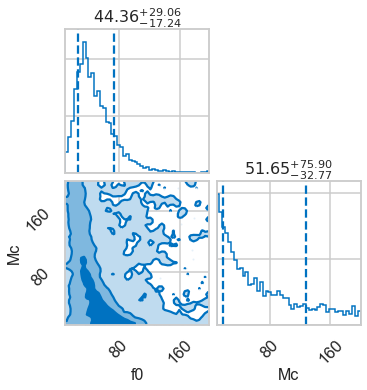

In [46]:
chirp_likelihood = ChirpLikelihood(times=times, freqs=freqs, Sxx=Sxx)
priors = dict(f0=Uniform(10, 200, 'f0'),
              Mc=Uniform(10, 200, 'Mc'))

result = bilby.run_sampler(likelihood=chirp_likelihood, priors=priors, sampler='dynesty', sample='unif',
                           nlive=1000)
result.plot_corner()

## Likelihood: summary

- A Bilby likelihood is a just a python "object" which
  - Inherits from `bilby.likelihood.Likelihood`
  - Has an attribute `parameters` (used to figure out what to sample over)
  - Has a method `log_likelihood()`

## Priors

- Bilby includes lots of built in priors
- Like the likelihood you can create your own from scratch

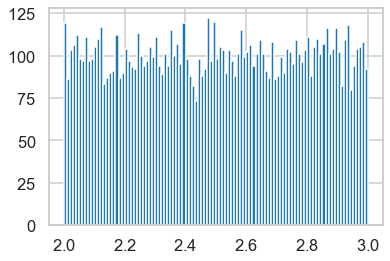

In [47]:
log_unif = bilby.core.prior.Uniform(2, 3)
_ = plt.hist(log_unif.sample(10000), bins=100)

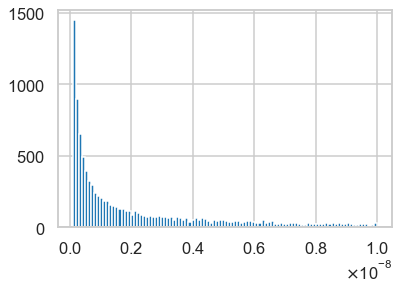

In [48]:
log_unif = bilby.core.prior.LogUniform(1e-10, 1e-8)
_ = plt.hist(log_unif.sample(10000), bins=100)

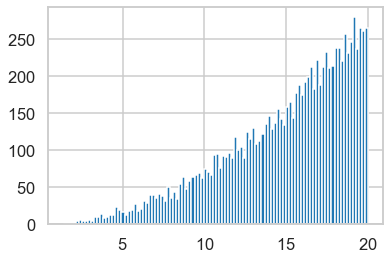

In [49]:
power = bilby.core.prior.PowerLaw(alpha=2, minimum=1, maximum=20)
_ = plt.hist(power.sample(10000), bins=100)

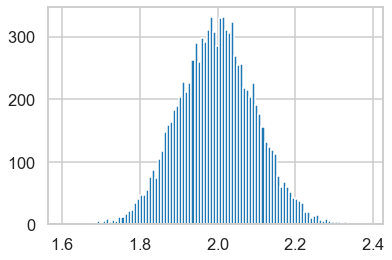

In [50]:
gauss = bilby.core.prior.Gaussian(mu=2, sigma=0.1)
_ = plt.hist(gauss.sample(10000), bins=100)

### We also provide the `PriorDict` which is useful for handling a set of priors

In [51]:
priors = bilby.prior.PriorDict(dict(
    x=bilby.prior.Uniform(0, 1, 'x'),
    y=bilby.prior.Cosine('y')))
prior_samples = priors.sample(10000)
prior_samples

{'x': array([0.70325912, 0.04771959, 0.4104765 , ..., 0.09882439,
        0.03670761, 0.01697814]),
 'y': array([ 0.205307  ,  1.18495711, -0.64819962, ...,  0.94708569,
         0.371421  , -0.35125612])}

## Plotting the prior samples

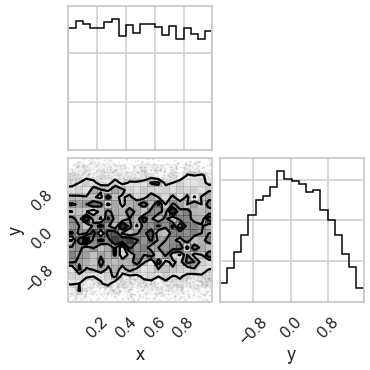

In [52]:
import corner
prior_samples_array = np.array([prior_samples['x'], prior_samples['y']]).T
corner.corner(prior_samples_array, labels=['x', 'y'])
plt.show()

## Constraints

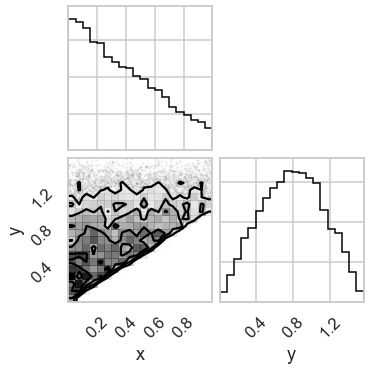

In [53]:
def conv(parameters):
    parameters['ratio'] = parameters['x'] / parameters['y']
    return parameters

priors = bilby.prior.PriorDict(dict(
    x=bilby.prior.Uniform(0, 1, 'x'),
    y=bilby.prior.Cosine('y'),
    ratio=bilby.prior.Constraint(minimum=0, maximum=1, name='ratio')),
    conversion_function=conv)

prior_samples = priors.sample(10000)
prior_samples_array = np.array([prior_samples['x'], prior_samples['y']]).T
corner.corner(prior_samples_array, labels=['x', 'y'])
plt.show()

## Conversions for convienience

Sample in different model parameters from your source model

13:55 bilby WARNING : Parameter omega has no default prior and is set to None, this will not be sampled and may cause an error.


8509it [00:15, 386.53it/s, bound:130 nc:15 ncall:116645 eff:7.3% logz=-81.20+/-0.11 dlogz:0.100>0.10] 
8511it [00:15, 539.61it/s, bound:130 nc:1 ncall:116680 eff:8.2% logz=-81.10+/-0.10 dlogz:0.000>0.10] 



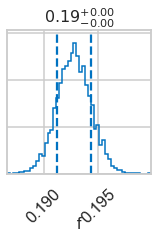

In [54]:
class ConversionGaussianLikelihood(GaussianLikelihood):
    def __init__(self, x, y, func, sigma, conversion_function):
        super(ConversionGaussianLikelihood, self).__init__(x=x, y=y, func=func, sigma=sigma)
        self.conversion_function = conversion_function
        
    def log_likelihood(self):
        self.parameters = self.conversion_function(self.parameters)
        log_l = np.sum(- (self.residual / self.sigma)**2 / 2 -
                       np.log(2 * np.pi * self.sigma**2) / 2)
        return log_l
    
def conv(parameters):
    parameters["omega"] = 2*np.pi*parameters["f"]
    return parameters

likelihood = ConversionGaussianLikelihood(
    time, yobs, modelA, sigma=sigma, conversion_function=conv)
priors = dict(f=Uniform(0, 2, 'f'))
result = bilby.run_sampler(likelihood, priors, clean=True)
result.plot_corner()

## Conversions in post-processing

Note: this isn't ideal behaviour as the `conversion_function` here acts differently to the one required by `PriorDict`. This may change in the future to fix this!

In [55]:
priors = dict(omega=Uniform(0, 2, 'omega'))
likelihood = GaussianLikelihood(time, yobs, modelA, sigma=sigma)

def posterior_conversion_function(data_frame, likelihood, priors):
    data_frame["f"] = data_frame["omega"] / (2 * np.pi)
    return data_frame

result = bilby.run_sampler(likelihood, priors, clean=True, conversion_function=posterior_conversion_function)
result.posterior.head()

6523it [00:11, 380.45it/s, bound:92 nc:20 ncall:89813 eff:7.3% logz=-79.25+/-0.09 dlogz:0.104>0.10] 
6556it [00:11, 549.23it/s, bound:93 nc:1 ncall:90411 eff:8.4% logz=-79.14+/-0.08 dlogz:0.000>0.10] 



,omega,log_likelihood,log_prior,f
0,1.171481,-82.572403,-0.693147,0.186447
1,1.248963,-81.647743,-0.693147,0.198779
2,1.174951,-81.284440,-0.693147,0.186999
3,1.246853,-80.928104,-0.693147,0.198443
4,1.176616,-80.709114,-0.693147,0.187264


# Choose your own adventure:

- Moritz Hübner's introduction to bilby [on colab](https://colab.research.google.com/drive/1PiQD4ZVA-cteqpcrhEZThkY9BLJAsdrK)

- Colm Talbot's introduction to GW inference with bilby [on colab](https://colab.research.google.com/gist/ColmTalbot/58dacd07a820d96ed0e1c43e2bf824c1/gravitational-wave-transient-inference-with-bilby.ipynb)


- Pick a dataset and try to fit to it!